In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

2025-04-21 18:44:08.126332: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745261048.367966      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745261048.440907      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [27]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D,
    GlobalAveragePooling2D, Dense, Dropout
)
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import ImageFile # Keep this for truncated images
import numpy as np
import os
import math # Needed for ceil calculation

# --- Configuration & Data Loading ---

# Allow loading of truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Define constants based on your data loading setup
IMG_SIZE = (224, 224)
DATASET_PATH = "/kaggle/input/augmenteddataset/DATASET"
WEIGHTS_PATH = "/kaggle/input/weights/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5" # Make sure this path is correct
SAVE_MODEL_PATH = "/kaggle/working/best_model_resnet_hop.keras" # Use .keras format

# From your data loading code
BATCH_SIZE = 32
# Let's define epochs for potentially two phases
EPOCHS_PHASE_1 = 15 # Adjust as needed (e.g., start with 10-20)
EPOCHS_PHASE_2 = 20 # For optional fine-tuning later (adjust as needed)

# Data Preprocessing & Augmentation
# Using your ImageDataGenerator setup
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2 # 80% Train, 20% Validation
)

# Validation generator should ONLY rescale (no augmentation)
# It's crucial to evaluate on non-augmented validation data
val_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=0.2 # Same split to get the corresponding validation set
)


# Load training and validation sets using flow_from_directory
print("Loading Training Data...")
train_ds = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="sparse", # Correct for sparse_categorical_crossentropy
    subset="training",
    shuffle=True # Shuffle training data
)

print("Loading Validation Data...")
val_ds = val_datagen.flow_from_directory( # Use val_datagen here!
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="sparse", # Correct for sparse_categorical_crossentropy
    subset="validation",
    shuffle=False # No need to shuffle validation data
)

# Get dataset information automatically
NUM_TRAIN_IMAGES = train_ds.samples
NUM_VAL_IMAGES = val_ds.samples
CLASSES = train_ds.num_classes
INPUT_SHAPE = (*IMG_SIZE, 3)

print(f"Found {NUM_TRAIN_IMAGES} training images belonging to {CLASSES} classes.")
print(f"Found {NUM_VAL_IMAGES} validation images belonging to {CLASSES} classes.")
print(f"Input shape: {INPUT_SHAPE}")
print(f"Number of classes: {CLASSES}")

# Calculate steps per epoch (ImageDataGenerator usually handles this, but good for CosineDecay)
steps_per_epoch_train = math.ceil(NUM_TRAIN_IMAGES / BATCH_SIZE)
steps_per_epoch_val = math.ceil(NUM_VAL_IMAGES / BATCH_SIZE)
print(f"Steps per training epoch: {steps_per_epoch_train}")
print(f"Steps per validation epoch: {steps_per_epoch_val}")

Loading Training Data...
Found 33609 images belonging to 3 classes.
Loading Validation Data...
Found 8400 images belonging to 3 classes.
Found 33609 training images belonging to 3 classes.
Found 8400 validation images belonging to 3 classes.
Input shape: (224, 224, 3)
Number of classes: 3
Steps per training epoch: 1051
Steps per validation epoch: 263


In [5]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow as tf

def conv_block(input_tensor, filters, stage, block, strides=(2, 2)):
    f1, f2, f3 = filters
    conv_name_base = f'res{stage}{block}_branch'
    bn_name_base = f'bn{stage}{block}_branch'

    x = Conv2D(f1, (1, 1), strides=strides, name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(f2, (3, 3), padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(f3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(name=bn_name_base + '2c')(x)

    shortcut = Conv2D(f3, (1, 1), strides=strides, name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(name=bn_name_base + '1')(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def identity_block(input_tensor, filters, stage, block):
    f1, f2, f3 = filters
    conv_name_base = f'res{stage}{block}_branch'
    bn_name_base = f'bn{stage}{block}_branch'

    x = Conv2D(f1, (1, 1), name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(f2, (3, 3), padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(f3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(name=bn_name_base + '2c')(x)

    x = Add()([x, input_tensor])
    x = Activation('relu')(x)
    return x

def adjust_dims(source, target_shape, name):
    stride_h = K.int_shape(source)[1] // target_shape[1]
    stride_w = K.int_shape(source)[2] // target_shape[2]
    return Conv2D(target_shape[-1], (1, 1), strides=(stride_h, stride_w), padding='valid', name=f'{name}_adjust')(source)

def ResNet50_hop(input_shape=(224, 224, 3), classes=3):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, (7, 7), strides=2, padding='same', name='conv1')(inputs)
    x = BatchNormalization(name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=2, padding='same', name='max_pool')(x)
    print("Initial MaxPool:", K.int_shape(x))
    block_outputs = {'maxpool': x}

    # Stage 2
    x = conv_block(x, [64, 64, 256], stage=2, block='a', strides=(1, 1)); block_outputs['a'] = x
    for blk in ['b', 'c', 'd']:
        x = identity_block(x, [64, 64, 256], stage=2, block=blk)
        block_outputs[blk] = x

    # Stage 3
    x = conv_block(x, [128, 128, 512], stage=3, block='e'); block_outputs['e'] = x
    for blk in ['f', 'g', 'h']:
        x = identity_block(x, [128, 128, 512], stage=3, block=blk)
        block_outputs[blk] = x
        print(f"Block {blk}:", K.int_shape(x))

    # Stage 4
    x = conv_block(x, [256, 256, 1024], stage=4, block='i'); block_outputs['i'] = x
    for blk in ['j', 'k', 'l', 'm', 'n']:
        x = identity_block(x, [256, 256, 1024], stage=4, block=blk)
        block_outputs[blk] = x
        print(f"Block {blk}:", K.int_shape(x))

    # Stage 5
    x = conv_block(x, [512, 512, 2048], stage=5, block='o'); block_outputs['o'] = x
    for blk in ['p', 'q', 'r']:
        x = identity_block(x, [512, 512, 2048], stage=5, block=blk)
        block_outputs[blk] = x
        print(f"Block {blk}:", K.int_shape(x))

    # Hop Connections
    def add_hop(src_blk, dest_blk):
        src = block_outputs[src_blk]
        dest = block_outputs[dest_blk]
        if K.int_shape(src) != K.int_shape(dest):
            src = adjust_dims(src, K.int_shape(dest), name=f'hop_{src_blk}_{dest_blk}')
        block_outputs[dest_blk] = Add(name=f'hop_add_{src_blk}_{dest_blk}')([dest, src])
        print(f"Hop from {src_blk} to {dest_blk} → {K.int_shape(block_outputs[dest_blk])}")

    add_hop('maxpool', 'c')
    add_hop('b', 'e')
    add_hop('d', 'g')
    add_hop('f', 'i')
    add_hop('h', 'k')
    add_hop('j', 'm')
    add_hop('l', 'o')
    add_hop('n', 'q')
    add_hop('p', 'r')

    # Final output
    x = GlobalAveragePooling2D(name='avg_pool')(block_outputs['r'])

    # Optimal Classification Head
    x = Dense(512, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(256, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    output = Dense(classes, activation="softmax")(x)

    model = Model(inputs, output, name='resnet50_hop_custom')
    return model
    
    model = ResNet50_hop()
    model.summary()


In [6]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.optimizers import Adam

# --- Instantiate the custom model ---
model = ResNet50_hop(input_shape=(224, 224, 3), classes=3)

# --- Load weights if needed ---
model.load_weights(
    "/kaggle/input/weights/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5",
    by_name=True,
    skip_mismatch=True
)

# --- Freeze base layers (optional for transfer learning) ---
for layer in model.layers:
    if "res" in layer.name or "conv" in layer.name:
        layer.trainable = False

# --- Optimizer with Cosine Decay ---
lr_schedule = CosineDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000
)
optimizer = Adam(learning_rate=lr_schedule)

# --- Compile the model ---
model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# --- Callbacks ---
checkpoint = ModelCheckpoint(
    filepath="/kaggle/working/best_model.keras",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)


I0000 00:00:1745209757.230098      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745209757.230763      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Initial MaxPool: (None, 56, 56, 64)
Block f: (None, 28, 28, 512)
Block g: (None, 28, 28, 512)
Block h: (None, 28, 28, 512)
Block j: (None, 14, 14, 1024)
Block k: (None, 14, 14, 1024)
Block l: (None, 14, 14, 1024)
Block m: (None, 14, 14, 1024)
Block n: (None, 14, 14, 1024)
Block p: (None, 7, 7, 2048)
Block q: (None, 7, 7, 2048)
Block r: (None, 7, 7, 2048)
Hop from maxpool to c → (None, 56, 56, 256)
Hop from b to e → (None, 28, 28, 512)
Hop from d to g → (None, 28, 28, 512)
Hop from f to i → (None, 14, 14, 1024)
Hop from h to k → (None, 14, 14, 1024)
Hop from j to m → (None, 14, 14, 1024)
Hop from l to o → (None, 7, 7, 2048)
Hop from n to q → (None, 7, 7, 2048)
Hop from p to r → (None, 7, 7, 2048)


![WhatsApp Image 2025-04-23 at 9.13.22 AM.jpeg](<attachment:WhatsApp Image 2025-04-23 at 9.13.22 AM.jpeg>)
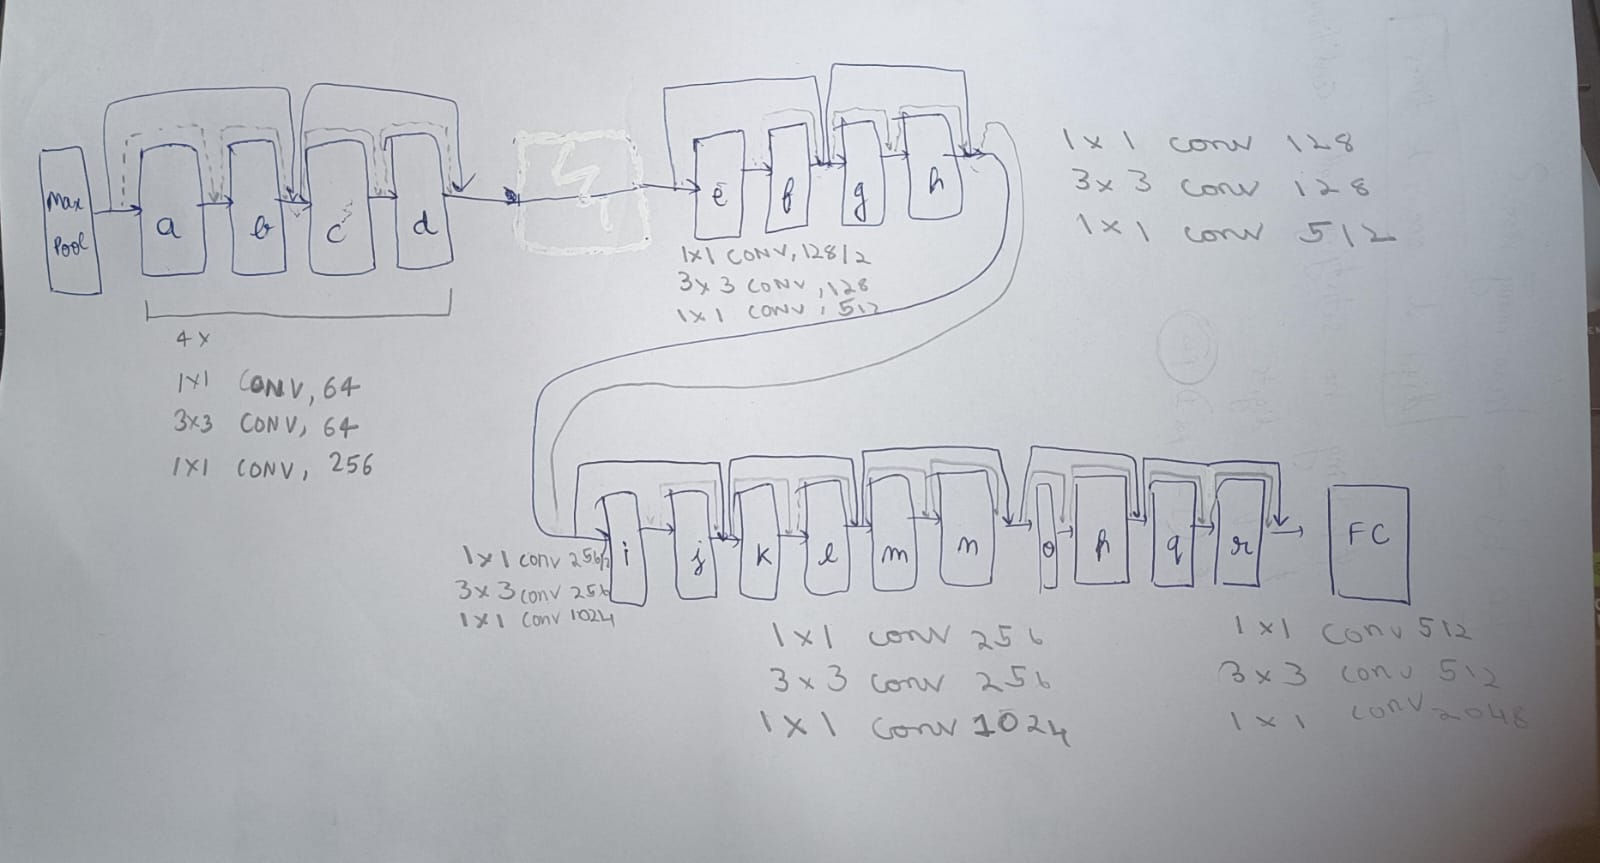

In [ ]:
# --- Training ---
print("Training initiated")

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,  
    callbacks=[checkpoint, reduce_lr]
)

# --- Evaluation ---
loss, accuracy = model.evaluate(val_ds)
print(f" Validation Accuracy: {accuracy * 100:.2f}%")

# --- Load Best Model from Checkpoint Before Evaluation ---
model.load_weights("/kaggle/working/best_model.keras")
print(" Loaded best model based on validation accuracy.")

# --- Evaluation ---
loss, accuracy = model.evaluate(val_ds)
print(f" Final Validation Accuracy: {accuracy * 100:.2f}%")

# --- Save Best Model ---
MODEL_PATH = "/kaggle/working/model_final.keras"
model.save(MODEL_PATH)
print(f" Best model saved successfully at {MODEL_PATH}")

Training initiated
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1745209799.055194     106 service.cc:148] XLA service 0x7c6aec015770 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745209799.056463     106 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1745209799.056488     106 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1745209802.831955     106 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1745209817.483551     106 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of th

 110/1051 ━━━━━━━━━━━━━━━━━━━━ 7:36 485ms/step - accuracy: 0.4423 - loss: 1.3184

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


1051/1051 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.5146 - loss: 1.0880
Epoch 1: val_accuracy improved from -inf to 0.45143, saving model to /kaggle/working/best_model.keras
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 630s 546ms/step - accuracy: 0.5147 - loss: 1.0879 - val_accuracy: 0.4514 - val_loss: 1.2457 - learning_rate: 0.0000e+00
Epoch 2/20
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.5835 - loss: 0.8876
Epoch 2: val_accuracy did not improve from 0.45143
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 455s 430ms/step - accuracy: 0.5835 - loss: 0.8876 - val_accuracy: 0.4404 - val_loss: 1.2735 - learning_rate: 0.0000e+00
Epoch 3/20
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.5830 - loss: 0.8753
Epoch 3: val_accuracy did not improve from 0.45143
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 448s 424ms/step - accuracy: 0.5830 - loss: 0.8753 - val_accuracy: 0.4455 - val_loss: 1.2507 - learning_rate: 0.0000e+00
Epoch 4/20
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.5838 - loss: 0

I0000 00:00:1745234780.029741      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745234780.030485      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
I0000 00:00:1745234787.531551      96 service.cc:148] XLA service 0x7e4f1c002cb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745234787.532661      96 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1745234787.532681      96 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1745234788.187567      96 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


I0000 00:00:1745234791.181108      96 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


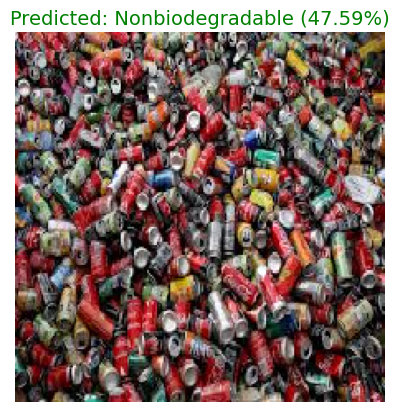

In [4]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

class_labels = ['Biodegradable', 'Nonbiodegradable', 'Recyclable']

model = tf.keras.models.load_model("/kaggle/input/model48/keras/default/1/best_model (4).keras",)

def predict_and_plot(img_path):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_expanded = np.expand_dims(img_array, axis=0)

    # Predict
    predictions = model.predict(img_expanded)
    predicted_class = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class] * 100
    predicted_label = class_labels[predicted_class]

    # Show the image and prediction
    plt.imshow((img_array * 255).astype(np.uint8))  # FIXED LINE
    plt.axis('off')
    plt.title(f"Predicted: {predicted_label} ({confidence:.2f}%)", fontsize=14, color='green')
    plt.show()

# Example usage
img_path = "/kaggle/input/testing/cens.jpg"  
predict_and_plot(img_path)

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Use a clean built‑in style
    plt.style.use('ggplot')

    epochs = list(range(1, len(history.history['loss']) + 1))

    # --- Loss Plot ---
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, history.history['loss'], marker='o', linestyle='-', linewidth=2, label='Train Loss')
    plt.plot(epochs, history.history['val_loss'], marker='s', linestyle='--', linewidth=2, label='Val Loss')
    plt.title('Training & Validation Loss', fontsize=18, fontweight='bold')
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.xticks(epochs)
    plt.grid(True, linestyle=':', linewidth=1)
    plt.legend(fontsize=12, frameon=True, edgecolor='black')
    plt.tight_layout()
    plt.show()

    # --- Accuracy Plot ---
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, history.history['accuracy'], marker='o', linestyle='-', linewidth=2, label='Train Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], marker='s', linestyle='--', linewidth=2, label='Val Accuracy')
    plt.title('Training & Validation Accuracy', fontsize=18, fontweight='bold')
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.xticks(epochs)
    plt.grid(True, linestyle=':', linewidth=1)
    plt.legend(fontsize=12, frameon=True, edgecolor='black')
    plt.tight_layout()
    plt.show()

# After training:
plot_training_history(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Images processed: 32
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Images processed: 64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Images processed: 96
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Images processed: 128
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Images processed: 160
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Images processed: 192
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Images processed: 224
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Images processed: 256
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Images processed: 288
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Images processed: 320
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Images processed: 352
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Images processed: 384
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Images processed: 416
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Images processed: 448
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Images processed: 480
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Images processed: 512
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Image

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Images processed: 3952
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Images processed: 3984
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Images processed: 4016
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Images processed: 4048
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Images processed: 4080
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Images processed: 4112
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Images processed: 4144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Images processed: 4176
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Images processed: 4208
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Images processed: 4240
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Images processed: 4272
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Images processed: 4304
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Images processed: 4336
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Images processed: 4368
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Images processed: 4400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Images processed: 4432
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Images processed: 4464
1

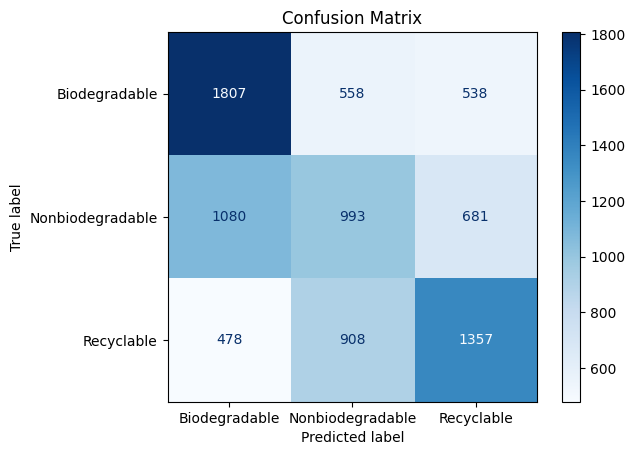

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Initialize lists to hold true and predicted labels
y_true = []
y_pred = []

# Counter to track number of images processed
images_processed = 0
limit = val_ds.samples  # Maximum number of images to process

# Generate predictions
for images, labels in val_ds:
    preds = model.predict(images)
    preds = np.argmax(preds, axis=1)

    # Limit handling
    batch_size = len(labels)
    if images_processed + batch_size > limit:
        # Trim batch to match the limit
        remaining = limit - images_processed
        y_true.extend(labels[:remaining])
        y_pred.extend(preds[:remaining])
        images_processed += remaining
        print(f"Images processed: {images_processed}")
        break
    else:
        y_true.extend(labels)
        y_pred.extend(preds)
        images_processed += batch_size
        print(f"Images processed: {images_processed}")

# Optional: convert to NumPy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Print classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=["Biodegradable", "Nonbiodegradable", "Recyclable"]))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Biodegradable", "Nonbiodegradable", "Recyclable"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Initialize lists for true and predicted labels
y_true = []
y_pred = []

# Counter for tracking images processed
images_processed = 0
limit = val_ds.samples  # Total number of images in validation dataset

# Loop through validation dataset
for images, labels in val_ds:
    # Make predictions
    preds = model.predict(images)
    preds = np.argmax(preds, axis=1)

    # Check if we have processed enough images
    batch_size = len(labels)
    if images_processed + batch_size > limit:
        # Only process the remaining images
        remaining = limit - images_processed
        y_true.extend(labels[:remaining])
        y_pred.extend(preds[:remaining])
        images_processed += remaining
        print(f"Images processed: {images_processed}/{limit}")
        break
    else:
        y_true.extend(labels)
        y_pred.extend(preds)
        images_processed += batch_size
        print(f"Images processed: {images_processed}/{limit}")

# Convert to NumPy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Compute and print Precision, Recall, and F1 Score
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print("\nFinal Metrics")
print(f"Precision (macro): {precision:.4f}")
print(f"Recall (macro): {recall:.4f}")
print(f"F1 Score (macro): {f1:.4f}")

# Generate and display confusion matrix
class_names = ["Biodegradable", "Nonbiodegradable", "Recyclable"]
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

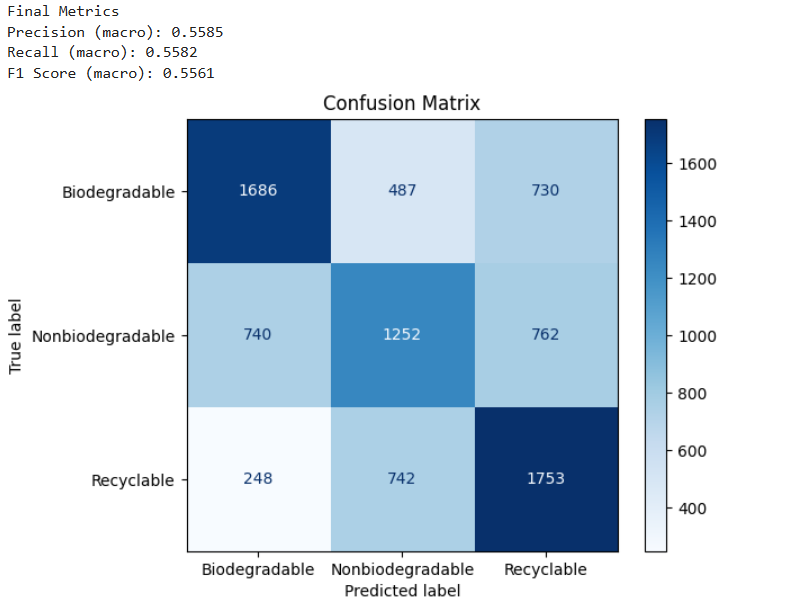
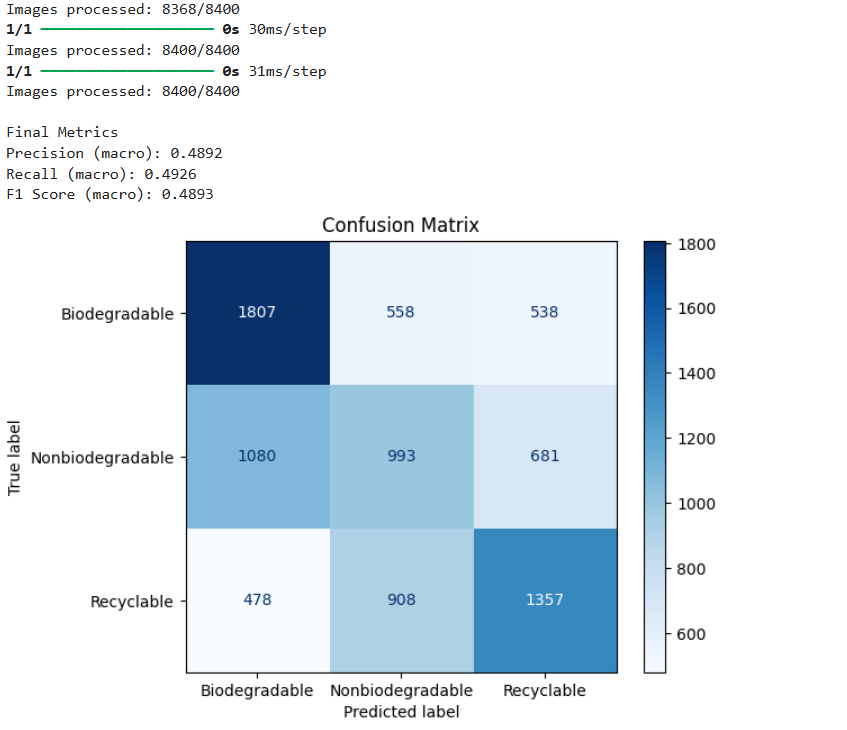